# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [2]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [3]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [4]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [5]:
PROJECT = 'velvety-ground-421111'  ### USING MY GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!gcloud config list # showing some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = fatemafidvi12@gmail.com
project = velvety-ground-421111
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [6]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://velvety-ground-421111-storage/...
ServiceException: 409 A Cloud Storage bucket named 'velvety-ground-421111-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))

GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

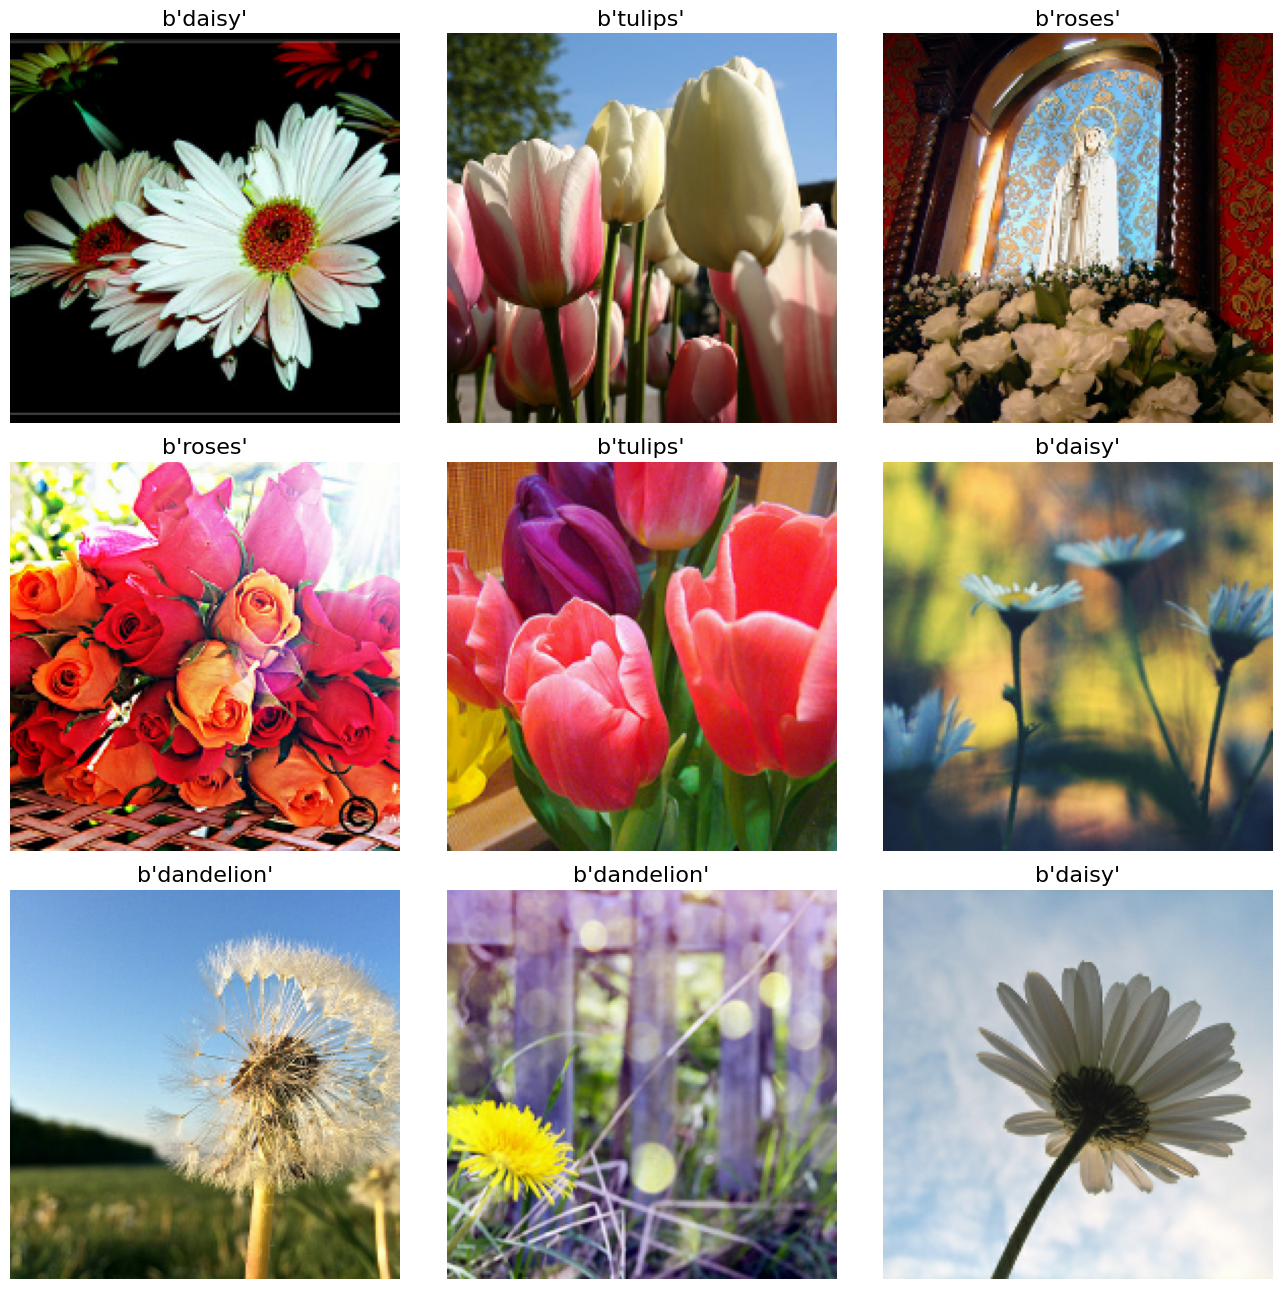

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'roses', 'tulips', 'daisy', 'dandelion', 'daisy', 'roses', 'roses', 'roses'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'dandelion', 'tulips', 'dandelion', 'tulips', 'roses', 'roses', 'roses', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'daisy', 'tulips', 'daisy', 'roses', 'daisy', 'roses', 'roses', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['daisy', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'sunflowers', 'roses'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'daisy', 'daisy', 'roses', 'dandelion', 'tulips', 'daisy', 'tulips', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'roses', 'sunflowers', 'roses', 'tulips', 'sunflowers', 'tulips', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'daisy', 'tulips', 'dandelion', 'dan

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['roses', 'dandelion', 'tulips', 'dandelion', 'tulips', 'roses', 'dandelion', 'tulips', 'tulips', 'roses'])
Image batch shape (10,), ['tulips', 'roses', 'tulips', 'roses', 'dandelion', 'tulips', 'sunflowers', 'sunflowers', 'dandelion', 'sunflowers'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'tulips', 'tulips'])
Image batch shape (10,), ['tulips', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'tulips'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'dandelion', 'tulips', 'tulips', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses'])
Image batch shape (10,), ['daisy', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'tulips', 'daisy'])
Image batch shape (10,), ['daisy', 'roses', 'roses', 'roses', 'dandelion', 'roses', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers'])
Image batch shape (1

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i]
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64)    # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['3', '1', '3', '2', '3', '4', '1', '0', '1', '0'])
Image batch shape (10, 192, 192, 3), ['2', '0', '1', '0', '0', '2', '0', '4', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '2', '4', '3', '3', '3', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['2', '1', '2', '1', '0', '4', '3', '1', '0', '2'])
Image batch shape (10, 192, 192, 3), ['3', '4', '4', '0', '3', '1', '1', '0', '4', '3'])
Image batch shape (10, 192, 192, 3), ['2', '4', '4', '1', '2', '3', '1', '4', '1', '1'])
Image batch shape (10, 192, 192, 3), ['3', '4', '2', '1', '4', '4', '1', '0', '2', '2'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '4', '1', '0', '4', '4', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '3', '1', '2', '1', '4', '0', '0'])
Image batch shape (10, 192, 192, 3), ['4', '4', '3', '0', '0', '2', '0', '0', '0', '1'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
from pyspark import SparkContext, SparkConf
import tensorflow as tf
import numpy as np
import os

# Define the Spark Context
sc = SparkContext.getOrCreate()

# Define the classes exactly like above
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Task 1a(i): Copy over the mapping functions and adapt resizing and recompression functions to Spark
# Define the preprocessing functions
def decode_jpeg_and_label(file_path):
    image_contents = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_contents)
    label = tf.strings.split(tf.expand_dims(file_path, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_recompress_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 192, 192)
    image = tf.cast(image, tf.uint8)
    return tf.io.encode_jpeg(image)

# Task 1a(ii): Initialize RDD with the list of image filenames
# Load image file paths into an RDD
file_paths_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

# Shuffle the RDD for randomness
shuffled_rdd = file_paths_rdd.map(lambda x: (x, None)).sortByKey().map(lambda x: x[0])

# Task 1a(iii): Sample the RDD to reduce the dataset size for quick tests (2% of the actual data)
sampled_rdd = shuffled_rdd.sample(False, 0.02)

# Task 1a(iv): Write TFRecord files
def write_tfrecord_to_file(partition_index, iterator):
    for idx, (img_bytes, label) in enumerate(iterator):
        filename = f"{GCS_OUTPUT}part-{partition_index:05d}-{idx:03d}.tfrecord"
        with tf.io.TFRecordWriter(filename) as out_file:
            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes.numpy()])),
                'class': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        yield filename

# Task 1a(v): writing to the TFRecord files put into a function, that is
# applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that we have a list of the created TFRecord files.
def preprocess_partition(partition_index, iterator):
    for file_path in iterator:
        image, label = decode_jpeg_and_label(file_path)
        resized_image = resize_and_recompress_image(image)
        yield (resized_image, CLASSES.index(label))

# Apply preprocessing functions to RDD
preprocessed_rdd = sampled_rdd.mapPartitionsWithIndex(preprocess_partition)

# Apply preprocessing functions to RDD and write TFRecord files with mapPartitionsWithIndex
output_files = preprocessed_rdd.mapPartitionsWithIndex(write_tfrecord_to_file).collect()

# Print the list of TFRecord files created
print("TFRecord files written:", output_files)

TFRecord files written: ['gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-000.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-001.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-002.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-003.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-004.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-005.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-006.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-007.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-008.tfrecord', 'gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowerspart-00000-009.tfrecord', 'gs://velvety-ground-421111-storage

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


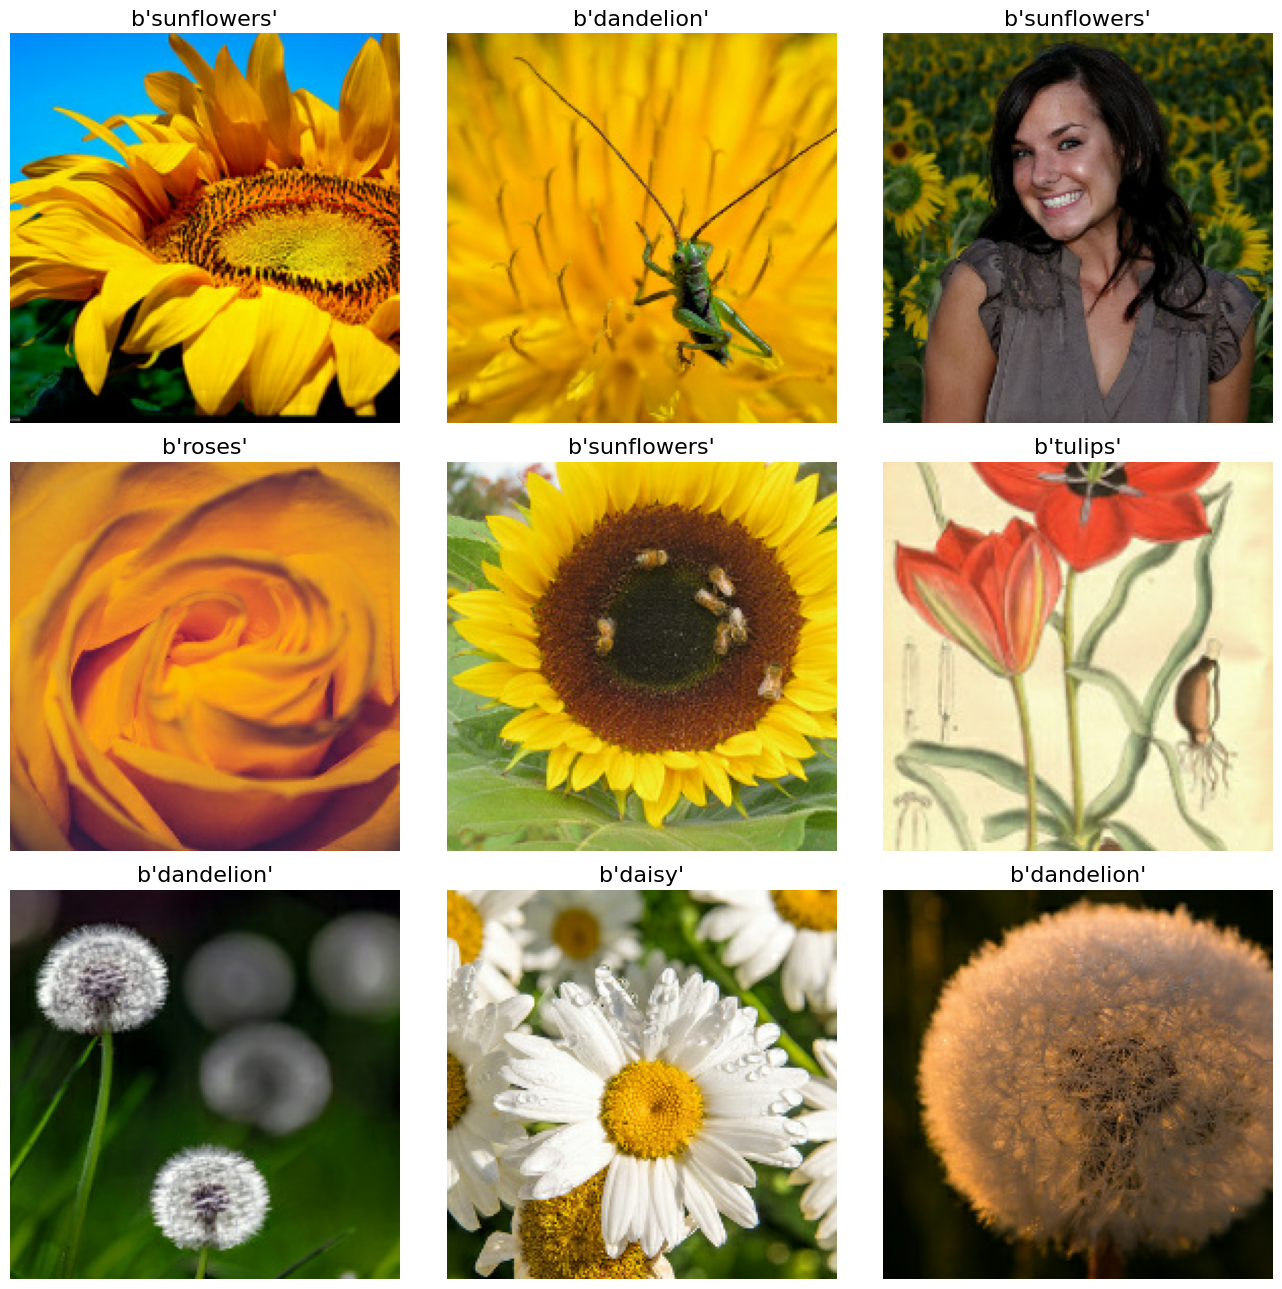

In [ ]:
# Function to read TFRecord example
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [192, 192, 3])
    class_num = example['class']
    class_name = tf.gather(CLASSES, class_num)
    return image, class_name

# display_9_images_from_dataset() and load_dataset is already defined
filenames = tf.io.gfile.glob(GCS_OUTPUT+ "*.tfrec")
dataset =load_dataset (filenames)
display_9_images_from_dataset(dataset)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%%writefile spark_write_tfrec.py

from pyspark import SparkContext, SparkConf
import tensorflow as tf
import numpy as np
import os
# again defining the gcs pattern file
GCS_PATTERN = 'gs://velvety-ground-421111/flowers-public//.jpg'

# Define the Spark Context
sc = SparkContext.getOrCreate()

# Define the classes exactly like above
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Task 1a(i): Copy over the mapping functions and adapt resizing and recompression functions to Spark
# Define the preprocessing functions
def decode_jpeg_and_label(file_path):
    image_contents = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_contents)
    label = tf.strings.split(tf.expand_dims(file_path, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_recompress_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 192, 192)
    image = tf.cast(image, tf.uint8)
    return tf.io.encode_jpeg(image)

# Task 1a(ii): Initialize RDD with the list of image filenames
# Load image file paths into an RDD
file_paths_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

# Shuffle the RDD for randomness
shuffled_rdd = file_paths_rdd.map(lambda x: (x, None)).sortByKey().map(lambda x: x[0])

# Task 1a(iii): Sample the RDD to reduce the dataset size for quick tests (2% of the actual data)
sampled_rdd = shuffled_rdd.sample(False, 0.02)

# Task 1a(iv): Write TFRecord files
def write_tfrecord_to_file(partition_index, iterator):
    for idx, (img_bytes, label) in enumerate(iterator):
        filename = f"{GCS_OUTPUT}part-{partition_index:05d}-{idx:03d}.tfrecord"
        with tf.io.TFRecordWriter(filename) as out_file:
            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes.numpy()])),
                'class': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        yield filename

# Task 1a(v): writing to the TFRecord files put into a function, that is
# applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that we have a list of the created TFRecord files.
def preprocess_partition(partition_index, iterator):
    for file_path in iterator:
        image, label = decode_jpeg_and_label(file_path)
        resized_image = resize_and_recompress_image(image)
        yield (resized_image, CLASSES.index(label))

# Apply preprocessing functions to RDD
preprocessed_rdd = sampled_rdd.mapPartitionsWithIndex(preprocess_partition)

# Apply preprocessing functions to RDD and write TFRecord files with mapPartitionsWithIndex
output_files = preprocessed_rdd.mapPartitionsWithIndex(write_tfrecord_to_file).collect()

# Print the list of TFRecord files created
print("TFRecord files written:", output_files)

Overwriting spark_write_tfrec.py


### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
# Setting up the Google Cloud SDK (Software Development Kit) and initializing
# Google Cloud configuration.

!curl https://sdk.cloud.google.com | bash
!gcloud init
project_id = 'velvety-ground-421111'
!gcloud config set project {project_id}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0   6187      0 --:--:-- --:--:-- --:--:--  6239
############################################################################################# 100.0%
Running install script from: /tmp/tmp.qKe0j34b3k/install_google_cloud_sdk.bash
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
############################################################################################# 100.0%

mkdir -p /root
"/root/google-cloud-sdk" already exists and may contain out of date files.
Remove /root/google-cloud-sdk or select a new installation directory, then run again.
Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  region: us-west1
  

- Forming the Single node Cluster

In [ ]:
REGION = 'us-central1'
ZONE = 'us-central1-c'
single_node_cluster = 'bd-cw-single-node-cluster'
PROJECT = 'velvety-ground-421111'

# Setting the default project and region for gcloud commands
!gcloud config set project $PROJECT
!gcloud config set dataproc/region $REGION

# Creating the Dataproc cluster with TensorFlow
!gcloud dataproc clusters create $single_node_cluster \
    --zone=$ZONE \
    --single-node \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy" \
    --project=$PROJECT

Updated property [core/project].
Updated property [dataproc/region].
Waiting on operation [projects/velvety-ground-421111/regions/us-central1/operations/43247bfd-4ee5-39ed-b31e-86cbbde96810].

Created [https://dataproc.googleapis.com/v1/projects/velvety-ground-421111/regions/us-central1/clusters/bd-cw-single-node-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# Describe the configuration details of a Google Cloud Dataproc cluster.
!gcloud dataproc clusters describe $CLUSTER

clusterName: bd-cw-single-node-cluster
clusterUuid: a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5
config:
  configBucket: dataproc-staging-us-central1-52101774534-1c6pu8yc
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 numpy
    networkUri: https://www.googleapis.com/compute/v1/projects/velvety-ground-421111/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/velvety-ground-421111/zones/us-central1-c
  initializationAction

In [ ]:
# Using the gsutil command-line tool to copy the script file (.py) from the local filesystem to a Google Cloud Storage (GCS) bucket
!gsutil cp spark_write_tfrec.py gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py

Copying file://spark_write_tfrec.py [Content-Type=text/x-python]...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


In [ ]:
# Displaying the contents of the file copied
!gsutil cat gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py


from pyspark import SparkContext, SparkConf
import tensorflow as tf
import numpy as np
import os
#Newly added line
GCS_PATTERN = 'gs://velvety-ground-421111/flowers-public//.jpg'
# Define the Spark Context
sc = SparkContext.getOrCreate()

# Define the classes
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Task 1a(i): Copy over the mapping functions and adapt resizing and recompression
# Define the preprocessing functions
def decode_jpeg_and_label(file_path):
    image_contents = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_contents)
    label = tf.strings.split(tf.expand_dims(file_path, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_recompress_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 192, 192)
    image = tf.cast(image, tf.uint8)
    return tf.io.encode_jpeg(image)

# Task 1a(ii): Replace TensorFlow Dataset objects with RDDs
# Load image file paths into an RDD and shuffle
file_paths_rdd = s

- WITHOUT PARELLELIZATION ON SINGLE NODE CLUSTER

In [ ]:
### without parallelization on single node cluster ###

import subprocess
import json
from datetime import datetime

# Define the name of the Dataproc cluster with 1 master node and 0 working nodes
single_node_cluster = 'bd-cw-single-node-cluster'
REGION = 'us-central1'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + single_node_cluster,
    '--region=' + REGION,
    'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py'
]

# Submit the PySpark job to the first cluster and capture the output
print(f"Submitting the job to cluster {single_node_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-cw-single-node-cluster...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/bab652101ad84c36a4f5a55149cced29/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/bab652101ad84c36a4f5a55149cced29/driveroutput
jobUuid: 3875fb58-9888-3f1a-bbff-797a3e58c2bd
placement:
  clusterName: bd-cw-single-node-cluster
  clusterUuid: a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py
reference:
  jobId: bab652101ad84c36a4f5a55149cced29
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T18:51:56.057741Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T18:51:29.960069Z'
- state: SETUP_DONE
  stateStartTime: '2024-04-29T18:51:29.98

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
### Creating cluster with maximal working node that is using 7 worker nodes and 1 master node in zone us-central1-c ###

REGION = "us-central1"
zone = "us-central1-c"
max_cluster = 'bd-maximal-cluster'

# Configuration for the master node
master_machine_type = 'n1-standard-1'
master_boot_disk_type = 'pd-ssd'
master_boot_disk_size = '100'  # Master node SSD capacity in GB

# Configuration for worker nodes
worker_machine_type = 'n1-standard-1'  # As we want the same machine type for workers
worker_boot_disk_type = 'pd-standard'  # standard disk for workers
worker_boot_disk_size = '285'  # Standard disk capacity in GB, divided by number of workers (2000 % 7)

# Total number of worker nodes
num_workers = '7'

# Set the project's region configuration
!gcloud config set dataproc/region {REGION}

# Create the Dataproc cluster
!gcloud dataproc clusters create {max_cluster} \
    --zone={zone} \
    --master-machine-type={master_machine_type} \
    --master-boot-disk-type={master_boot_disk_type} \
    --master-boot-disk-size={master_boot_disk_size} \
    --num-workers={num_workers} \
    --worker-machine-type={worker_machine_type} \
    --worker-boot-disk-type={worker_boot_disk_type} \
    --worker-boot-disk-size={worker_boot_disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 scipy pandas numpy matplotlib protobuf==3.20.1"

Updated property [dataproc/region].
ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Multiple validation errors:
 - Insufficient 'CPUS' quota. Requested 8.0, available 0.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'CPUS_ALL_REGIONS' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'INSTANCES' quota. Requested 8.0, available 3.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'IN_USE_ADDRESSES' quota. Reque

- As the quotas are insufficient in us central region, trying to create maximal cluster in another region that is in the west

In [ ]:
# Setting up the Google Cloud SDK to change the zone to us west
# Google Cloud configuration.

!curl https://sdk.cloud.google.com | bash
!gcloud init
project_id = 'velvety-ground-421111'
!gcloud config set project {project_id}

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2015-09-17/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2015-09-17/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2015-09-17/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2015-09-17/waiters-2.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-13/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-13/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-13/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-13/waiters-2.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-28/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-28/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/cloudfront/2016-01-28/s

In [ ]:
### Creating cluster with maximal working node in the west region to check if the quotas are available there or not ###

region_west = "us-west1"
zone = "us-west1-c"
max_cluster_west = 'bd-maximal-cluster-west'

# Configuration for the master node
master_machine_type = 'n1-standard-1'
master_boot_disk_type = 'pd-ssd'
master_boot_disk_size = '100'  # Master node SSD capacity in GB

# Configuration for worker nodes
worker_machine_type = 'n1-standard-1'
worker_boot_disk_type = 'pd-standard'
worker_boot_disk_size = '100'

# Total number of worker nodes
num_workers = '7'

# Set the project's region configuration
!gcloud config set dataproc/region {region_west}

# Create the Dataproc cluster
!gcloud dataproc clusters create {max_cluster_west} \
    --zone={zone} \
    --master-machine-type={master_machine_type} \
    --master-boot-disk-type={master_boot_disk_type} \
    --master-boot-disk-size={master_boot_disk_size} \
    --num-workers={num_workers} \
    --worker-machine-type={worker_machine_type} \
    --worker-boot-disk-type={worker_boot_disk_type} \
    --worker-boot-disk-size={worker_boot_disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 scipy pandas numpy matplotlib protobuf==3.20.1"

Updated property [dataproc/region].
ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Multiple validation errors:
 - Insufficient 'CPUS' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'CPUS_ALL_REGIONS' quota. Requested 8.0, available 0.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'INSTANCES' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'IN_USE_ADDRESSES' quota. Reque

- Even in the other zones and, even after deleting all the clusters, the quotas are coming as insufficient, so making the maximal cluster in us-central1-c zone with 4 nodes, 3 working nodes and 1 mastere node

In [ ]:
### Creating cluster with maximal working node ###

REGION = "us-central1"
zone = "us-central1-c"
max_cluster = 'bd-maximal-cluster-central-4'

# Configuration for the master node
master_machine_type = 'n1-standard-1'
master_boot_disk_type = 'pd-ssd'
master_boot_disk_size = '100'  # Master node SSD capacity in GB

# Configuration for worker nodes
worker_machine_type = 'n1-standard-1'  # As we want the same machine type for workers
worker_boot_disk_type = 'pd-standard'  # standard disk for workers
worker_boot_disk_size = '100'  # as only 100 is working and if we go higher, it gives us error of quotas

# Total number of worker nodes (maximum)
num_workers = '3'

# Setting the project's region configuration
!gcloud config set dataproc/region {REGION}

# Creating the Dataproc cluster
!gcloud dataproc clusters create {max_cluster} \
    --zone={zone} \
    --master-machine-type={master_machine_type} \
    --master-boot-disk-type={master_boot_disk_type} \
    --master-boot-disk-size={master_boot_disk_size} \
    --num-workers={num_workers} \
    --worker-machine-type={worker_machine_type} \
    --worker-boot-disk-type={worker_boot_disk_type} \
    --worker-boot-disk-size={worker_boot_disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 scipy pandas numpy matplotlib protobuf==3.20.1"

Updated property [dataproc/region].
Waiting on operation [projects/velvety-ground-421111/regions/us-central1/operations/dddbfdd4-33b3-3c44-85fd-daca80caf56c].

Created [https://dataproc.googleapis.com/v1/projects/velvety-ground-421111/regions/us-central1/clusters/bd-maximal-cluster-central-4] Cluster placed in zone [us-central1-c].


- This maximal cluster with 3 working nodes and 1 master node is only crerated without the quota error when i stop the other clusters running in the background

In [ ]:
# Checking the quotas for my project
!gcloud compute project-info describe --project velvety-ground-421111

cloudArmorTier: CA_STANDARD
commonInstanceMetadata:
  fingerprint: exTNq_LhDec=
  kind: compute#metadata
creationTimestamp: '2024-04-22T05:04:19.053-07:00'
defaultNetworkTier: PREMIUM
defaultServiceAccount: 52101774534-compute@developer.gserviceaccount.com
id: '6161907492957449389'
kind: compute#project
name: velvety-ground-421111
quotas:
- limit: 1000.0
  metric: SNAPSHOTS
  usage: 0.0
- limit: 5.0
  metric: NETWORKS
  usage: 1.0
- limit: 100.0
  metric: FIREWALLS
  usage: 4.0
- limit: 100.0
  metric: IMAGES
  usage: 0.0
- limit: 8.0
  metric: STATIC_ADDRESSES
  usage: 0.0
- limit: 200.0
  metric: ROUTES
  usage: 0.0
- limit: 15.0
  metric: FORWARDING_RULES
  usage: 0.0
- limit: 50.0
  metric: TARGET_POOLS
  usage: 0.0
- limit: 75.0
  metric: HEALTH_CHECKS
  usage: 0.0
- limit: 4.0
  metric: IN_USE_ADDRESSES
  usage: 0.0
- limit: 50.0
  metric: TARGET_INSTANCES
  usage: 0.0
- limit: 10.0
  metric: TARGET_HTTP_PROXIES
  usage: 0.0
- limit: 10.0
  metric: URL_MAPS
  usage: 0.0
- limit: 

- WITHOUT PARELLELIZATION ON MAXIMAL CLUSTER (using 3 worker nodes and 1 master node)

In [ ]:
### WITHOUT PARELLELIZATION ON MAXIMAL CLUSTER ###

import subprocess
import json
from datetime import datetime

# Define the cluster, region, and script path
max_cluster = 'bd-maximal-cluster-central-4'
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + max_cluster,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the Dataproc cluster and capture the output
print(f"Submitting the job to cluster {max_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-maximal-cluster-central-4...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/8345447e73bc416086b33cb6b8602ea0/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/8345447e73bc416086b33cb6b8602ea0/driveroutput
jobUuid: 3f049ff7-a38a-388d-9fd8-fb95c811ce42
placement:
  clusterName: bd-maximal-cluster-central-4
  clusterUuid: 5676c8ea-1af9-4f53-8dd6-a8062f60b9eb
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py
reference:
  jobId: 8345447e73bc416086b33cb6b8602ea0
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T19:37:38.412319Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T19:36:11.441009Z'
- state: SETUP_DONE
  stateStartTime: '2024-04-29T19:36

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

In [ ]:
# 1d) i)Improve parallelisation
# 1b script with parellelization
# changing the name of the spark file with parellelization
%%writefile spark_write_tfrec_parellel.py

from pyspark import SparkContext, SparkConf
import tensorflow as tf
import numpy as np
import os

GCS_PATTERN = 'gs://velvety-ground-421111-storage/flowers-public//.jpg'

# Define the Spark Context
sc = SparkContext.getOrCreate()

# Define the classes exactly like above
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Task 1a(i): Copy over the mapping functions and adapt resizing and recompression functions to Spark
# Define the preprocessing functions
def decode_jpeg_and_label(file_path):
    image_contents = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_contents)
    label = tf.strings.split(tf.expand_dims(file_path, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_recompress_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 192, 192)
    image = tf.cast(image, tf.uint8)
    return tf.io.encode_jpeg(image)

# Task 1a(ii): Initialize RDD with the list of image filenames
# Load image file paths into an RDD
file_paths_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

# Shuffle the RDD for randomness
shuffled_rdd = file_paths_rdd.map(lambda x: (x, None)).sortByKey().map(lambda x: x[0])

# Task 1a(iii): Sample the RDD to reduce the dataset size for quick tests (2% of the actual data)
sampled_rdd = shuffled_rdd.sample(False, 0.02)

# Task 1a(iv): Write TFRecord files
def write_tfrecord_to_file(partition_index, iterator):
    for idx, (img_bytes, label) in enumerate(iterator):
        filename = f"{GCS_OUTPUT}part-{partition_index:05d}-{idx:03d}.tfrecord"
        with tf.io.TFRecordWriter(filename) as out_file:
            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes.numpy()])),
                'class': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        yield filename

# Task 1a(v): writing to the TFRecord files put into a function, that is
# applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that we have a list of the created TFRecord files.
def preprocess_partition(partition_index, iterator):
    for file_path in iterator:
        image, label = decode_jpeg_and_label(file_path)
        resized_image = resize_and_recompress_image(image)
        yield (resized_image, CLASSES.index(label))

# Apply preprocessing functions to RDD
preprocessed_rdd = sampled_rdd.mapPartitionsWithIndex(preprocess_partition)

# Apply preprocessing functions to RDD and write TFRecord files with mapPartitionsWithIndex
output_files = preprocessed_rdd.mapPartitionsWithIndex(write_tfrecord_to_file).collect()

# Print the list of TFRecord files created
print("TFRecord files written:", output_files)

Writing spark_write_tfrec_parellel.py


In [ ]:
# Copy the Python script to the location in Google Cloud Storage
!gsutil cp spark_write_tfrec.py gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py

Copying file://spark_write_tfrec.py [Content-Type=text/x-python]...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


- WITH PARELLELIZATION ON SINGLE NODE CLUSTER

In [ ]:
### WITH PARELLELIZATION (18) ON SINGLE NODE CLUSTER ###
 # 1d) i)Improve parallelisation
import subprocess
import json
from datetime import datetime

# Define the cluster and region
single_node_cluster = "bd-cw-single-node-cluster"
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + single_node_cluster,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the first cluster and capture the output
print(f"Submitting the job to cluster {single_node_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-cw-single-node-cluster...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/0876001f96be4c32b67c01203e835718/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/0876001f96be4c32b67c01203e835718/driveroutput
jobUuid: bb1b7ca9-1daa-37c4-ba14-4456db888546
placement:
  clusterName: bd-cw-single-node-cluster
  clusterUuid: a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py
reference:
  jobId: 0876001f96be4c32b67c01203e835718
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T19:18:31.947219Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T19:18:08.340321Z'
- state: SETUP_DONE
  stateStartTime: '2024-04-29T19

- WITH PARELLELIZATION ON MAXIMAL CLUSTER

In [ ]:
# WITH PARELLELIZATION (18) ON MAXIMAL CLUSTER
 # 1d) i)Improve parallelisation
import subprocess
import json
from datetime import datetime

# Define the cluster and region
max_cluster = "bd-maximal-cluster-central-4"
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + max_cluster,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the cluster and capture the output
print(f"Submitting the job to cluster {max_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-maximal-cluster-central-4...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/38899800a81f439780ddfd5698f1e9f3/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/38899800a81f439780ddfd5698f1e9f3/driveroutput
jobUuid: f21a84ad-7768-3e4e-809e-111f9cc063a3
placement:
  clusterName: bd-maximal-cluster-central-4
  clusterUuid: 5676c8ea-1af9-4f53-8dd6-a8062f60b9eb
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py
reference:
  jobId: 38899800a81f439780ddfd5698f1e9f3
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T19:46:13.885501Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T19:45:02.063099Z'
- state: SETUP_DONE
  stateStartTime: '2024-04

In [10]:
# 1d) i)Improve parallelisation
# 1b script with parellelization
# changing the name of the spark file with parellelization
%%writefile spark_write_tfrec_40.py

from pyspark import SparkContext, SparkConf
import tensorflow as tf
import numpy as np
import os
# from above
GCS_PATTERN = 'gs://velvety-ground-421111-storage/flowers-public//.jpg'

# Define the Spark Context
sc = SparkContext.getOrCreate()

# Define the classes exactly like above
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Task 1a(i): Copy over the mapping functions and adapt resizing and recompression functions to Spark
# Define the preprocessing functions
def decode_jpeg_and_label(file_path):
    image_contents = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_contents)
    label = tf.strings.split(tf.expand_dims(file_path, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_recompress_image(image):
    image = tf.image.resize_with_crop_or_pad(image, 192, 192)
    image = tf.cast(image, tf.uint8)
    return tf.io.encode_jpeg(image)

# Task 1a(ii): Initialize RDD with the list of image filenames
# Load image file paths into an RDD
file_paths_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

# Shuffle the RDD for randomness
shuffled_rdd = file_paths_rdd.map(lambda x: (x, None)).sortByKey().map(lambda x: x[0])

# Task 1a(iii): Sample the RDD to reduce the dataset size for quick tests (2% of the actual data)
sampled_rdd = shuffled_rdd.sample(False, 0.02)

# Task 1a(iv): Write TFRecord files
def write_tfrecord_to_file(partition_index, iterator):
    for idx, (img_bytes, label) in enumerate(iterator):
        filename = f"{GCS_OUTPUT}part-{partition_index:05d}-{idx:03d}.tfrecord"
        with tf.io.TFRecordWriter(filename) as out_file:
            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes.numpy()])),
                'class': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        yield filename

# Task 1a(v): writing to the TFRecord files put into a function, that is
# applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that we have a list of the created TFRecord files.
def preprocess_partition(partition_index, iterator):
    for file_path in iterator:
        image, label = decode_jpeg_and_label(file_path)
        resized_image = resize_and_recompress_image(image)
        yield (resized_image, CLASSES.index(label))

# Apply preprocessing functions to RDD
preprocessed_rdd = sampled_rdd.mapPartitionsWithIndex(preprocess_partition)

# Apply preprocessing functions to RDD and write TFRecord files with mapPartitionsWithIndex
output_files = preprocessed_rdd.mapPartitionsWithIndex(write_tfrecord_to_file).collect()

# Print the list of TFRecord files created
print("TFRecord files written:", output_files)

Writing spark_write_tfrec_40.py


In [11]:
# Copy the Python script to the location in Google Cloud Storage
!gsutil cp spark_write_tfrec_40.py gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py

Copying file://spark_write_tfrec_40.py [Content-Type=text/x-python]...
-
Operation completed over 1 objects/2.9 KiB.                                      


- WITH PARELLELIZATION ON SINGLE NODE CLUSTER WITH 40 PARTITION

In [ ]:
### WITH PARELLELIZATION ON SINGLE NODE CLUSTER WITH 40 PARTITION###
 # 1d) i)Improve parallelisation
import subprocess
import json
from datetime import datetime

# Define the cluster and region
single_node_cluster = "bd-cw-single-node-cluster"
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + single_node_cluster,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the first cluster and capture the output
print(f"Submitting the job to cluster {single_node_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-cw-single-node-cluster...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/b9d101f9723d433391895d20c1542823/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5/jobs/b9d101f9723d433391895d20c1542823/driveroutput
jobUuid: 4d3f51c3-96c6-3b41-ac5e-7c0355ad7ab2
placement:
  clusterName: bd-cw-single-node-cluster
  clusterUuid: a2b9a747-cce0-4d55-9ea6-ffdbbee5bbe5
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py
reference:
  jobId: b9d101f9723d433391895d20c1542823
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T20:34:03.364856Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T20:33:30.063955Z'
- state: SETUP_DONE
  stateStartTime: '2024-04-29T20:33:30

- WITH PARELLELIZATION ON MAXIMAL CLUSTER ON 40 PARTITIONS

In [ ]:
# WITH PARELLELIZATION ON MAXIMAL CLUSTER ON 40 PARTITIONS
 # 1d) i)Improve parallelisation
import subprocess
import json
from datetime import datetime

# Define the cluster and region
max_cluster = "bd-maximal-cluster-central-4"
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + max_cluster,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the cluster and capture the output
print(f"Submitting the job to cluster {max_cluster}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-maximal-cluster-central-4...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/8692ef53ca5e41e98090f0495ebcf1fa/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/5676c8ea-1af9-4f53-8dd6-a8062f60b9eb/jobs/8692ef53ca5e41e98090f0495ebcf1fa/driveroutput
jobUuid: efab891e-3cf0-3696-8703-56a906740e11
placement:
  clusterName: bd-maximal-cluster-central-4
  clusterUuid: 5676c8ea-1af9-4f53-8dd6-a8062f60b9eb
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py
reference:
  jobId: 8692ef53ca5e41e98090f0495ebcf1fa
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-04-29T20:24:40.617781Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-04-29T20:24:03.737482Z'
- state: SETUP_DONE
  stateStartTime: '2024-04-29T20

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)



1. For 4 machines with double the resources (2 vCPUs each):

In [67]:
region = "us-central1"
zone = "us-central1-c"
cluster_name = 'bd-cluster-4machines-2vcpus'

# Configuration for the master node
master_machine_type = 'n1-standard-2'
master_boot_disk_type = 'pd-ssd'
master_boot_disk_size = '200'  # Master node SSD capacity in GB

# Configuration for worker nodes
worker_machine_type = 'n1-standard-2'
worker_boot_disk_type = 'pd-standard'
worker_boot_disk_size = '200'  # double disk capacity

# Total number of worker nodes
num_workers = '3'

# Set the project's region configuration
!gcloud config set dataproc/region {region}

# Create the Dataproc cluster
!gcloud dataproc clusters create {cluster_name} \
    --zone={zone} \
    --master-machine-type={master_machine_type} \
    --master-boot-disk-type={master_boot_disk_type} \
    --master-boot-disk-size={master_boot_disk_size} \
    --num-workers={num_workers} \
    --worker-machine-type={worker_machine_type} \
    --worker-boot-disk-type={worker_boot_disk_type} \
    --worker-boot-disk-size={worker_boot_disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 scipy pandas numpy matplotlib protobuf==3.20.1"

Updated property [dataproc/region].
Waiting on operation [projects/velvety-ground-421111/regions/us-central1/operations/81c8acb0-5f2b-38eb-bcd9-c692a2cf7f40].

Created [https://dataproc.googleapis.com/v1/projects/velvety-ground-421111/regions/us-central1/clusters/bd-cluster-4machines-2vcpus] Cluster placed in zone [us-central1-c].


In [73]:
### WITH PARELLELIZATION USING 40 NUMSLICES ON CLUSTER WITH 4 machines with double the resources (2 vCPUs each)###
import subprocess
import json
from datetime import datetime

# Define the cluster and region
CLUSTER = 'bd-cluster-4machines-2vcpus'
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + CLUSTER,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the first cluster and capture the output
print(f"Submitting the job to cluster {CLUSTER}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-cluster-4machines-2vcpus...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/af77c61f-3e21-4073-a44c-0ed83e054f17/jobs/18ef260500fe4d99af564ff298cad3f2/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/af77c61f-3e21-4073-a44c-0ed83e054f17/jobs/18ef260500fe4d99af564ff298cad3f2/driveroutput
jobUuid: 955f1086-ddf3-3c81-adbc-6a088d805da1
placement:
  clusterName: bd-cluster-4machines-2vcpus
  clusterUuid: af77c61f-3e21-4073-a44c-0ed83e054f17
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py
reference:
  jobId: 18ef260500fe4d99af564ff298cad3f2
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-05-01T18:11:55.940606Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-05-01T18:11:08.624267Z'
- state: SETUP_DONE
  stateStartTime: '2024-05-01T18:1

2. For 1 machine with eightfold resources:

In [74]:
#defining variables for the region, zone, cluster name, and GCS bucket
project_id = 'velvety-ground-421111'
region = 'us-central1'
zone = 'us-central1-c'
cluster_name = 'bd-cluster-1machine-eighfold'
bucket_name = 'velvety-ground-421111-storage'

#setting the default project and region for gcloud commands
!gcloud config set project $PROJECT
!gcloud config set dataproc/region $REGION

#creating a dataproc cluster with specified configuration
!gcloud dataproc clusters create {cluster_name} \
    --zone={zone} \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 800 \
    --initialization-actions gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0" \
    --project={project_id}

Updated property [core/project].
Updated property [dataproc/region].
ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'SSD_TOTAL_GB' quota. Requested 800.0, available 250.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.


As we have the quota capacity of only 250, we can't work with eightfold resources as needed.

In [76]:
# As we only have 250 availaible ssd, lets create our cluster with the available resources and not 800 ssd
cluster_name = 'bd-cluster-1machine-eighfold'

#setting the default project and region for gcloud commands
!gcloud config set project $PROJECT
!gcloud config set dataproc/region $REGION

#creating a dataproc cluster with specified configuration
!gcloud dataproc clusters create {cluster_name} \
    --zone={zone} \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 250 \
    --initialization-actions gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0" \
    --project={project_id}

Updated property [core/project].
Updated property [dataproc/region].
Waiting on operation [projects/velvety-ground-421111/regions/us-central1/operations/c011a1e4-8c61-3d7b-a4b6-82eaef87d5f5].

Created [https://dataproc.googleapis.com/v1/projects/velvety-ground-421111/regions/us-central1/clusters/bd-cluster-1machine-eighfold] Cluster placed in zone [us-central1-c].


In [77]:
### WITH PARELLELIZATION USING 40 NUMSLICES ON CLUSTER WITH 1 machine and 250 ssd###
import subprocess
import json
from datetime import datetime

# Define the cluster and region
CLUSTER = 'bd-cluster-1machine-eighfold'
REGION = "us-central1"
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py'

# Command to submit the PySpark job
command = [
    'gcloud', 'dataproc', 'jobs', 'submit', 'pyspark',
    '--cluster=' + CLUSTER,
    '--region=' + REGION,
    script_path
]

# Submit the PySpark job to the first cluster and capture the output
print(f"Submitting the job to cluster {CLUSTER}...")
try:
    submit_output = subprocess.run(command, capture_output=True, text=True, check=True)
    print(submit_output.stdout)  # Prints everything output by the command

    # Extracting job ID from the output
    job_id_line = [line for line in submit_output.stdout.splitlines() if "jobId:" in line]
    job_id = job_id_line[0].split(":")[1].strip() if job_id_line else None
    if job_id:
        print(f"Job ID: {job_id}")

except subprocess.CalledProcessError as e:
    print("Failed to submit job:")
    print(e.stderr)

Submitting the job to cluster bd-cluster-1machine-eighfold...
done: true
driverControlFilesUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/c11d8254-3620-4c34-a697-d1b01352266b/jobs/ec1173f8f3bb414c80e5b1e5e759ba29/
driverOutputResourceUri: gs://dataproc-staging-us-central1-52101774534-1c6pu8yc/google-cloud-dataproc-metainfo/c11d8254-3620-4c34-a697-d1b01352266b/jobs/ec1173f8f3bb414c80e5b1e5e759ba29/driveroutput
jobUuid: cf73d753-f28a-3d8f-903d-3723d349eb7b
placement:
  clusterName: bd-cluster-1machine-eighfold
  clusterUuid: c11d8254-3620-4c34-a697-d1b01352266b
pysparkJob:
  mainPythonFileUri: gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py
reference:
  jobId: ec1173f8f3bb414c80e5b1e5e759ba29
  projectId: velvety-ground-421111
status:
  state: DONE
  stateStartTime: '2024-05-01T18:27:15.359449Z'
statusHistory:
- state: PENDING
  stateStartTime: '2024-05-01T18:26:45.230949Z'
- state: SETUP_DONE
  stateStartTime: '2024-05-01T18


iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'tulips'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w'

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
# 2a vii) Write the code into a file using the cell magic %%writefile spartk_job.py
%%writefile spark_job.py

from pyspark import SparkContext
import itertools
import time
import numpy as np
import tensorflow as tf
import pickle
import subprocess
import datetime
import sys

# Global variable definitions
PROJECT = 'velvety-ground-421111'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
TARGET_SIZE = [192, 192]

# Functions to handle the datasets
# 2a i) Combine previous cells to create a dataset and parameter combinations in an RDD

# All these functions are copied as it is from above in section one as they we given defined to us
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def load_dataset4():
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image)
    dataset4 = dsetResized.map(recompress_image)
    return dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    tw, th = TARGET_SIZE[1], TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h]))
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

# Spark context initialization
sc = SparkContext.getOrCreate()

# Parameter combinations and RDD creation
batch_sizes = [2, 4, 8, 12, 16, 20]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers, repetitions))

# Task 2a i) Create an RDD from the combinations of parameters
parameters_rdd = sc.parallelize(parameter_combinations)

# Define the function to test configurations and collect performance data
def time_configs(batch_size, batch_number, repetition):
    datasets = [('TFRecord', load_dataset(filenames)), ('JPEG', load_dataset4())]
    results = []
    for dataset_name, dataset in datasets:
        dataset = dataset.batch(batch_size)
        local_elapsed_times = []
        local_images_per_second = []
        for _ in range(repetition):
            start_time = time.time()
            for _ in dataset.take(batch_number):
                pass
            elapsed_time = time.time() - start_time
            images_per_second = (batch_size * batch_number) / elapsed_time
            local_images_per_second.append(images_per_second)
            local_elapsed_times.append(elapsed_time)
        # Calculate averages for the repetitions
        avg_images_per_second = np.mean(local_images_per_second)
        avg_elapsed_time = np.mean(local_elapsed_times)
        results.append((dataset_name, (batch_size, batch_number, repetition), avg_images_per_second, avg_elapsed_time))
    return results

# Execute the time_configs function and collect results
results_rdd = parameters_rdd.flatMap(lambda x: time_configs(*x))
collected_results = results_rdd.collect() # Task 2a ii) and Task 2a iii)

# Task 2a iii) Print the performance results for each parameter combinations with their throughput
print("2a iii) Parameter Combinations with their throughputs:")
for result in collected_results:
    print(f"Dataset: {result[0]}, Parameters: {result[1]}, Average Images per Second: {result[2]}")

# 2a iv (aggregate images per sec per parameter value)
param_performance_rdd = results_rdd.flatMap(lambda x: [
    (('batch_size', x[1][0], x[0]), x[2]),
    (('batch_number', x[1][1], x[0]), x[2]),
    (('repetition', x[1][2], x[0]), x[2])
])
aggregated_param_performance = param_performance_rdd.groupByKey().mapValues(lambda vals: sum(vals) / len(vals)).collect() # Task 2a iv)

# Print results for 2a iv)
print("2a iv) Parameter Specific Performance:")
for param, performance in aggregated_param_performance:
    print(f"Parameter: {param}, Average Images per Second: {performance}")

# 2a v) (Average reading speeds for each parameter)
average_speed_rdd = param_performance_rdd.mapValues(lambda x: (x, 1)).reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
).mapValues(lambda x: x[0] / x[1])
average_speed_results = average_speed_rdd.collect() # Task 2a v)

#  Print the performance results of 2a v)
print("2a v) Average Reading Speeds for each parameter value:")
for param, avg_speed in average_speed_results:
    print(f"Parameter: {param}, Average Reading Speed: {avg_speed}")

# Task 2a vi) Save results to a single pickle file for both datasets
# writing all the results that is for 2a iii, iv and v results in the pickle files
def write_results_to_file(detailed_results, aggregated_performance, average_speeds):
    # Check if a filename is provided through command line arguments
    filename = "throughput_results_for_both_datasets.pkl"
    if len(sys.argv) > 1:
        filename = sys.argv[1]  # Use provided filename if available

    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    filename_with_timestamp = f"{filename[:-4]}_{timestamp}.pkl"
    pickle_file_path = f'/tmp/{filename_with_timestamp}'

    with open(pickle_file_path, 'wb') as f:
        pickle.dump({
            'detailed_results': detailed_results,
            'aggregated_performance': aggregated_performance,
            'average_speeds': average_speeds
        }, f)
    bucket_path = f'gs://velvety-ground-421111-storage/{filename_with_timestamp}'
    subprocess.run(['gsutil', 'cp', pickle_file_path, bucket_path], check=True)  # Task 2a vi)

# Close the Spark context
sc.stop()

Writing spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
import datetime

# Generate a timestamped filename to ensure uniqueness
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
filename = f"results_{timestamp}.pkl"

# Run the Spark job script with the new filename as an argument
%run spark_job.py {filename}

2a iii) Parameter Combinations with their throughputs:
Dataset: TFRecord, Parameters: (2, 3, 1), Average Images per Second: 15.72359862119208
Dataset: JPEG, Parameters: (2, 3, 1), Average Images per Second: 5.6448953334069065
Dataset: TFRecord, Parameters: (2, 3, 2), Average Images per Second: 22.703256335266992
Dataset: JPEG, Parameters: (2, 3, 2), Average Images per Second: 11.524632441994807
Dataset: TFRecord, Parameters: (2, 3, 3), Average Images per Second: 30.922661103082046
Dataset: JPEG, Parameters: (2, 3, 3), Average Images per Second: 11.931240651991493
Dataset: TFRecord, Parameters: (2, 6, 1), Average Images per Second: 69.15122230022986
Dataset: JPEG, Parameters: (2, 6, 1), Average Images per Second: 16.518546573030722
Dataset: TFRecord, Parameters: (2, 6, 2), Average Images per Second: 78.11333803523291
Dataset: JPEG, Parameters: (2, 6, 2), Average Images per Second: 15.261980938395537
Dataset: TFRecord, Parameters: (2, 6, 3), Average Images per Second: 33.166948175054074


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
# First, copy the PySpark script to Google Cloud Storage
!gsutil cp /root/spark_job.py gs://velvety-ground-421111-storage/scripts/spark_job.py

# Set the path to PySpark script in Google Cloud Storage
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_job.py'

# Submit the PySpark job to the Dataproc cluster
!gcloud dataproc jobs submit pyspark {script_path} \
    --cluster=bd-maximal-cluster-central-4 \
    --region=us-central1

Copying file:///root/spark_job.py [Content-Type=text/x-python]...
/ [1 files][  6.6 KiB/  6.6 KiB]                                                
Operation completed over 1 objects/6.6 KiB.                                      
Job [26bbcdf1dbbf442cbf7d22940c10ea1f] submitted.
Waiting for job output...
2024-04-30 12:50:31.475378: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 12:50:31.475539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/30 12:50:37 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 12:50:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 12:50:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 12:50:

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

Q - Why is caching implemented in the place it it?
- Ans - In the Spark job code for 2a, caching was implemented in 2c to enhance performance by preventing the repeated computation of the same RDD (results_rdd). This RDD is utilized multiple times for collecting performance metrics, aggregating data, and calculating averages, each of which would otherwise trigger a complete re-evaluation of the RDD from the beginning, including expensive read and map operations. Caching `results_rdd` immediately after its creation and before any operations like `collect()` optimizes the process by ensuring that heavy computations are done just once and subsequent operations access this precomputed data quickly, enhancing overall efficiency.

In [ ]:
# 2a vii) Write the code into a file using the cell magic %%writefile spartk_job.py
%%writefile spark_job_with_caching.py

from pyspark import SparkContext
import itertools
import time
import numpy as np
import tensorflow as tf
import pickle
import subprocess
import datetime
import sys

# Global variable definitions
PROJECT = 'velvety-ground-421111'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
TARGET_SIZE = [192, 192]

# Functions to handle the datasets
# 2a i) Combine previous cells to create a dataset and parameter combinations in an RDD
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def load_dataset4():
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image)
    dataset4 = dsetResized.map(recompress_image)
    return dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    tw, th = TARGET_SIZE[1], TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h]))
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

# Spark context initialization
sc = SparkContext.getOrCreate()

# Parameter combinations and RDD creation
batch_sizes = [2, 4, 8, 12, 16, 20]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers, repetitions))

# Task 2a i) Create an RDD from the combinations of parameters
parameters_rdd = sc.parallelize(parameter_combinations)

# Define the function to test configurations and collect performance data
def time_configs(batch_size, batch_number, repetition):
    datasets = [('TFRecord', load_dataset(filenames)), ('JPEG', load_dataset4())]
    results = []
    for dataset_name, dataset in datasets:
        dataset = dataset.batch(batch_size)
        local_elapsed_times = []
        local_images_per_second = []
        for _ in range(repetition):
            start_time = time.time()
            for _ in dataset.take(batch_number):
                pass
            elapsed_time = time.time() - start_time
            images_per_second = (batch_size * batch_number) / elapsed_time
            local_images_per_second.append(images_per_second)
            local_elapsed_times.append(elapsed_time)
        # Calculate averages for the repetitions
        avg_images_per_second = np.mean(local_images_per_second)
        avg_elapsed_time = np.mean(local_elapsed_times)
        results.append((dataset_name, (batch_size, batch_number, repetition), avg_images_per_second, avg_elapsed_time))
    return results

# Execute the time_configs function and collect results
results_rdd = parameters_rdd.flatMap(lambda x: time_configs(*x))
results_rdd = results_rdd.cache()          ### Task 2c ####
collected_results = results_rdd.collect()

# Task 2a iii) Print the performance results for each parameter combinations with their throughput
print("2a iii) Parameter Combinations with their throughputs:")
for result in collected_results:
    print(f"Dataset: {result[0]}, Parameters: {result[1]}, Average Images per Second: {result[2]}")

# 2a iv (aggregate images per sec per parameter value)
param_performance_rdd = results_rdd.flatMap(lambda x: [
    (('batch_size', x[1][0], x[0]), x[2]),
    (('batch_number', x[1][1], x[0]), x[2]),
    (('repetition', x[1][2], x[0]), x[2])
])
aggregated_param_performance = param_performance_rdd.groupByKey().mapValues(lambda vals: sum(vals) / len(vals)).collect() # Task 2a iv)

# Print results for 2a iv)
print("2a iv) Parameter Specific Performance:")
for param, performance in aggregated_param_performance:
    print(f"Parameter: {param}, Average Images per Second: {performance}")

# 2a v) (Average reading speeds for each parameter)
average_speed_rdd = param_performance_rdd.mapValues(lambda x: (x, 1)).reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
).mapValues(lambda x: x[0] / x[1])
average_speed_results = average_speed_rdd.collect()

#  Print the performance results of 2a v)
print("2a v) Average Reading Speeds for each parameter value:")
for param, avg_speed in average_speed_results:
    print(f"Parameter: {param}, Average Reading Speed: {avg_speed}")

# Task 2a vi) Save results to a single pickle file for both datasets
# writing all the results that is for 2a iii, iv and v results in the pickle files
def write_results_to_file(detailed_results, aggregated_performance, average_speeds):
    # Check if a filename is provided through command line arguments
    filename = "throughput_results_for_both_datasets.pkl"
    if len(sys.argv) > 1:
        filename = sys.argv[1]  # Use provided filename if available

    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    filename_with_timestamp = f"{filename[:-4]}_{timestamp}.pkl"
    pickle_file_path = f'/tmp/{filename_with_timestamp}'

    with open(pickle_file_path, 'wb') as f:
        pickle.dump({
            'detailed_results': detailed_results,
            'aggregated_performance': aggregated_performance,
            'average_speeds': average_speeds
        }, f)
    bucket_path = f'gs://velvety-ground-421111-storage/{filename_with_timestamp}'
    subprocess.run(['gsutil', 'cp', pickle_file_path, bucket_path], check=True)

# Close the Spark context
sc.stop()

Writing spark_job_with_caching.py


In [ ]:
# copy the PySpark script to Google Cloud Storage
!gsutil cp /root/spark_job_with_caching.py gs://velvety-ground-421111-storage/scripts/spark_job_with_caching.py

# Set the path to PySpark script in Google Cloud Storage with caching
script_path = 'gs://velvety-ground-421111-storage/scripts/spark_job_with_caching.py'

# Submit the PySpark job with caching to the Dataproc cluster
!gcloud dataproc jobs submit pyspark {script_path} \
    --cluster=bd-maximal-cluster-central-4 \
    --region=us-central1

Copying file:///root/spark_job_with_caching.py [Content-Type=text/x-python]...
/ [1 files][  6.6 KiB/  6.6 KiB]                                                
Operation completed over 1 objects/6.6 KiB.                                      
Job [b55abcc402e1492497bfaa4ca524828d] submitted.
Waiting for job output...
2024-05-01 01:20:23.632751: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-01 01:20:23.632923: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/01 01:20:32 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/01 01:20:32 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/01 01:20:32 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24

- This just ran in 14 minutes while before caching, the job took around 43 minutes to run with the same parameters defined

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

- Creating a table for TFRECORD DATASET

In [ ]:
import pandas as pd
# Filter collected_results for TFRecord dataset
tfrecord_results = [result for result in collected_results if result[0] == 'TFRecord']

# Convert TFRecord results to DataFrame
df_tfrecord = pd.DataFrame(tfrecord_results, columns=['Dataset', 'Parameters', 'Average Images per Second', 'Reading Speed'])

# Split the Parameters column into separate columns
df_tfrecord[['Batch Size', 'Batch Number', 'Repetitions']] = pd.DataFrame(df_tfrecord['Parameters'].tolist(), index=df_tfrecord.index)

# Drop the Parameters combination column
df_tfrecord.drop(columns=['Parameters'], inplace=True)

# Pivot the DataFrame to have parameter combinations as rows and average images per second and reading speed as columns
pivot_tfrecord = df_tfrecord.pivot_table(values=['Average Images per Second', 'Reading Speed'], index=['Batch Size', 'Batch Number', 'Repetitions'], aggfunc='mean')

# Reset index to make the parameter combinations as columns
pivot_tfrecord.reset_index(inplace=True)

# Calculate data size as the product of Batch Size and Batch Number
pivot_tfrecord['Batch Data Volume'] = pivot_tfrecord['Batch Size'] * pivot_tfrecord['Batch Number']

# Print the modified DataFrame
print("TFRecord Dataset table:")
pivot_tfrecord

TFRecord Dataset table:


Batch Size  Batch Number  Repetitions  Average Images per Second  \
0            2             3            1                   9.025670   
1            2             3            2                  36.905246   
2            2             3            3                  44.252821   
3            2             6            1                  33.388846   
4            2             6            2                  46.971625   
..         ...           ...          ...                        ...   
67          20             9            2                 602.578180   
68          20             9            3                 457.907159   
69          20            12            1                 594.115089   
70          20            12            2                 545.819274   
71          20            12            3                 488.740047   

    Reading Speed  Batch Data Volume  
0        0.664771                  6  
1        0.163810                  6  
2        0.139695                  6  
3        0.359401                 12  
4        0.289376                 12  
..            ...                ...  
67       0.302161                180  
68       0.641369                180  
69       0.403962                240  
70       0.442857                240  
71       0.511123                240  

[72 rows x 6 columns]

- Linear Regression of TFRECORD DATASET

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Perform linear regression individually for each parameter
def individual_regressions(pivot_tfrecord):
    results = []
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']
    for param in parameters:
        X = pivot_tfrecord[[param]]
        y_images = pivot_tfrecord['Average Images per Second']
        y_speed = pivot_tfrecord['Reading Speed']

        # Linear regression for Average Images per Second
        lr_images = LinearRegression()
        lr_images.fit(X, y_images)

        # Linear regression for Reading Speed
        lr_speed = LinearRegression()
        lr_speed.fit(X, y_speed)

        results.append({
            'Parameter': param,
            'Slope (Throughput)': lr_images.coef_[0],
            'Intercept (Throughput)': lr_images.intercept_,
            'Slope (Reading Speed)': lr_speed.coef_[0],
            'Intercept (Reading Speed)': lr_speed.intercept_
        })

    return pd.DataFrame(results)

# Calculate individual regressions
regression_results_tfrec = individual_regressions(pivot_tfrecord)
regression_results_tfrec

Parameter  Slope (Throughput)  Intercept (Throughput)  \
0         Batch Size           23.503925               62.101497   
1       Batch Number           27.063281              102.000783   
2        Repetitions           16.590107              271.795177   
3  Batch Data Volume            2.727811               93.570063   

   Slope (Reading Speed)  Intercept (Reading Speed)  
0               0.004626                   0.207935  
1               0.006558                   0.206559  
2              -0.017965                   0.291672  
3               0.000784                   0.194977

- Plot the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number (FOR TFRECORD DATASET)

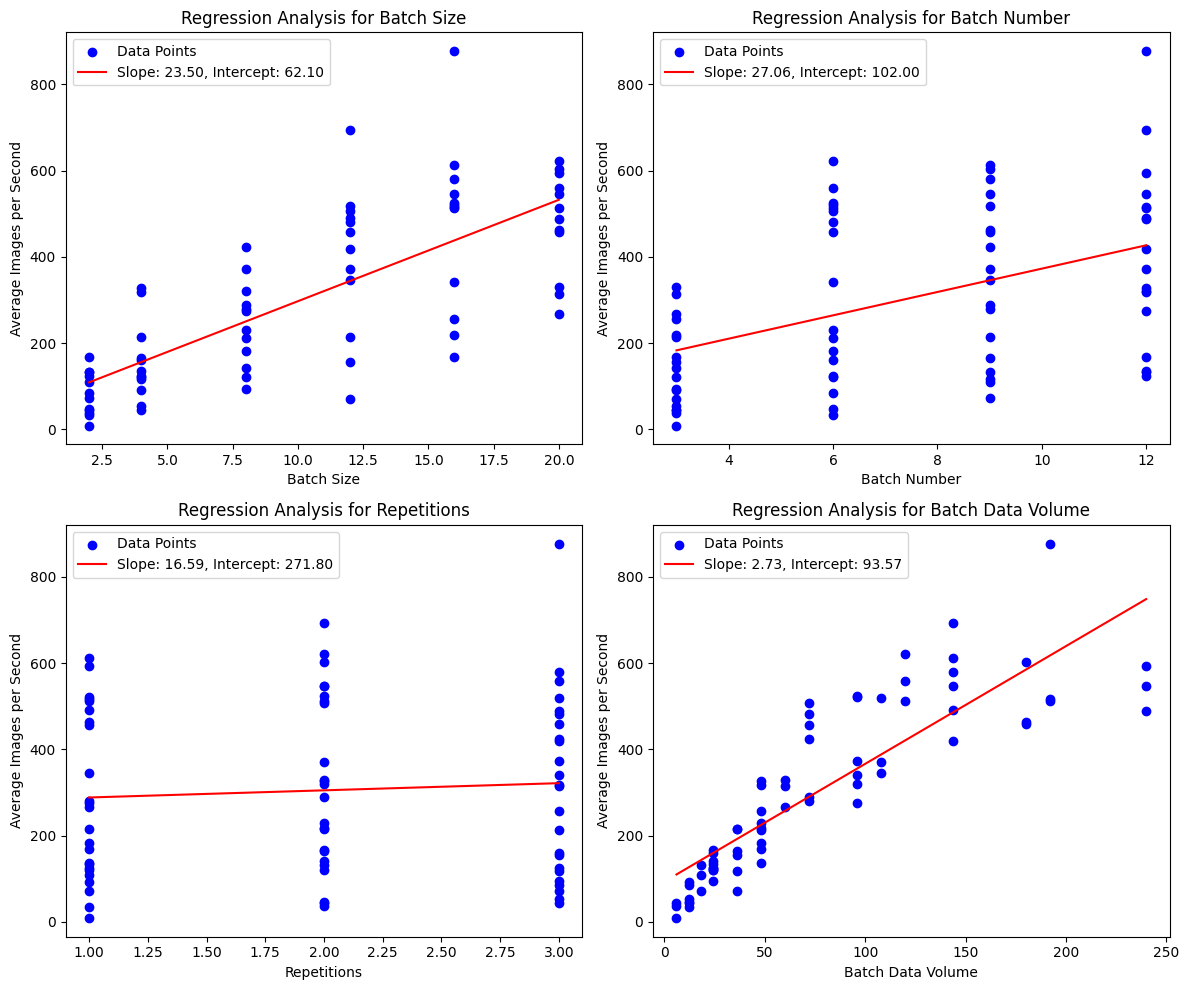

In [ ]:
# plotting average images per second for tfrecord dataset

def plot_regression_lines(pivot_tfrecord, regression_results_tfrec):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']

    for i, param in enumerate(parameters):
        ax = axes[i]
        X = pivot_tfrecord[[param]]
        y = pivot_tfrecord['Average Images per Second']

        # Get slopes and intercepts
        slope = regression_results_tfrec.loc[regression_results_tfrec['Parameter'] == param, 'Slope (Throughput)'].values[0]
        intercept = regression_results_tfrec.loc[regression_results_tfrec['Parameter'] == param, 'Intercept (Throughput)'].values[0]

        # Scatter plot
        ax.scatter(X, y, color='blue', label='Data Points')
        ax.set_xlabel(param)
        ax.set_ylabel('Average Images per Second')
        ax.set_title(f'Regression Analysis for {param}')

        # Plot regression line
        x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Reshape x_values
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, 'r-', label=f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Run the plotting function
plot_regression_lines(pivot_tfrecord, regression_results_tfrec)

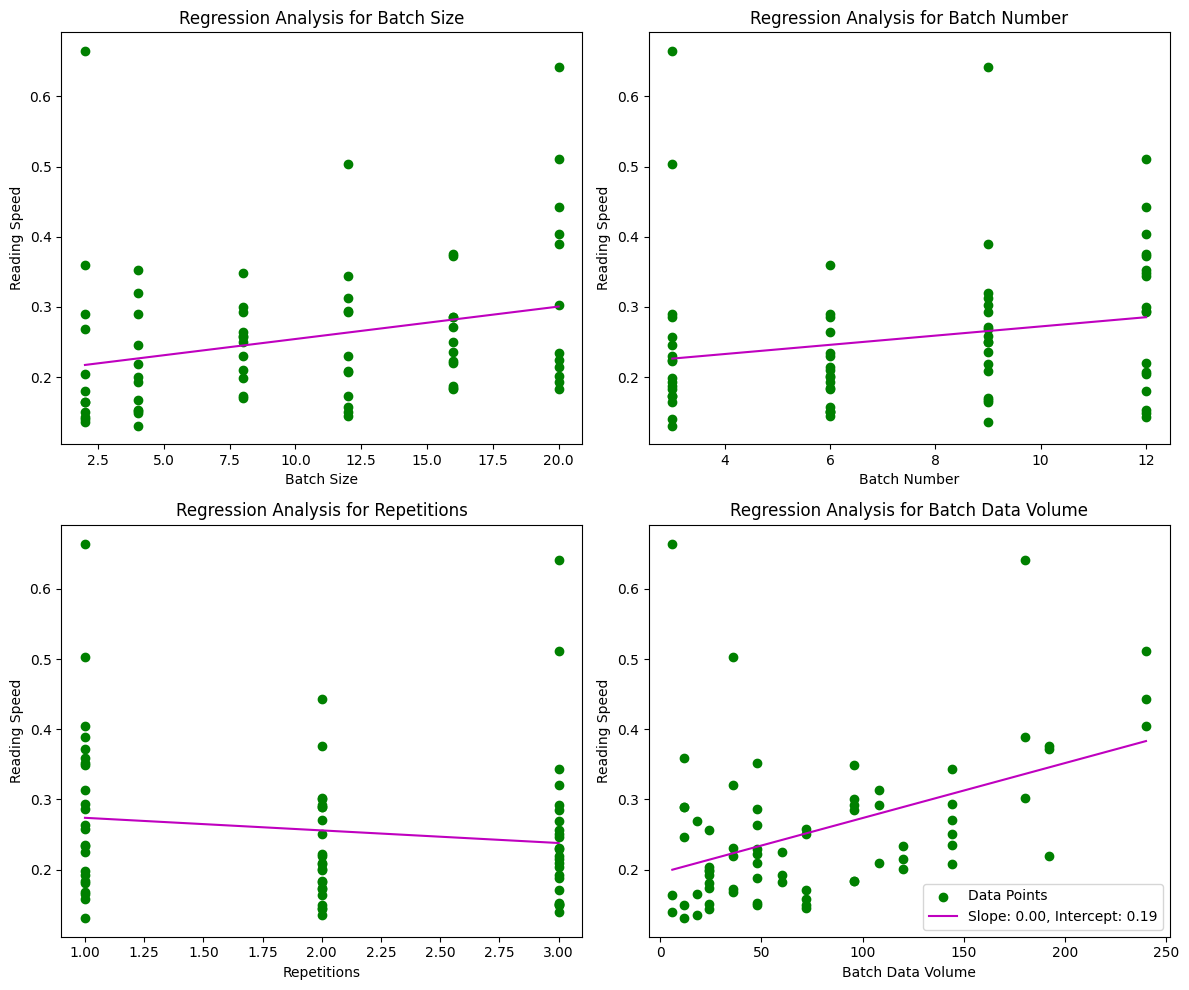

In [ ]:
# plotting the points for reading speeds for tfrecord dataset

def plot_reading_speed_regression(pivot_tfrecord, regression_results_tfrec):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']

    for i, param in enumerate(parameters):
        ax = axes[i]
        X = pivot_tfrecord[[param]]
        y = pivot_tfrecord['Reading Speed']

        # Get slopes and intercepts
        slope = regression_results_tfrec.loc[regression_results_tfrec['Parameter'] == param, 'Slope (Reading Speed)'].values[0]
        intercept = regression_results_tfrec.loc[regression_results_tfrec['Parameter'] == param, 'Intercept (Reading Speed)'].values[0]

        # Scatter plot
        ax.scatter(X, y, color='green', label='Data Points')
        ax.set_xlabel(param)
        ax.set_ylabel('Reading Speed')
        ax.set_title(f'Regression Analysis for {param}')

        # Plot regression line
        x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Reshape x_values
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, 'm-', label=f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Run the plotting function for reading speeds
plot_reading_speed_regression(pivot_tfrecord, regression_results_tfrec)

- Creating a table for IMAGES DATASET (DATASET4)

In [ ]:
# Filter collected_results for JPEG dataset
jpeg_results = [result for result in collected_results if result[0] == 'JPEG']

# Convert JPEG results to DataFrame
df_jpeg = pd.DataFrame(jpeg_results, columns=['Dataset', 'Parameters', 'Average Images per Second', 'Reading Speed'])

# Split the Parameters column into separate columns
df_jpeg[['Batch Size', 'Batch Number', 'Repetitions']] = pd.DataFrame(df_jpeg['Parameters'].tolist(), index=df_jpeg.index)

# Drop the Parameters combination column
df_jpeg.drop(columns=['Parameters'], inplace=True)

# Pivot the DataFrame to have parameter combinations as rows and average images per second and reading speed as columns
pivot_jpeg = df_jpeg.pivot_table(values=['Average Images per Second', 'Reading Speed'], index=['Batch Size', 'Batch Number', 'Repetitions'], aggfunc='mean')

# Reset index to make the parameter combinations as columns
pivot_jpeg.reset_index(inplace=True)

# Calculate data size as the product of Batch Size and Batch Number
pivot_jpeg['Batch Data Volume'] = pivot_jpeg['Batch Size'] * pivot_jpeg['Batch Number']

# Print the pivoted JPEG DataFrame
print("JPEG Dataset dataframe:")
pivot_jpeg

JPEG Dataset dataframe:


Batch Size  Batch Number  Repetitions  Average Images per Second  \
0            2             3            1                   7.245344   
1            2             3            2                   8.503932   
2            2             3            3                   8.081391   
3            2             6            1                  10.387001   
4            2             6            2                   9.206681   
..         ...           ...          ...                        ...   
67          20             9            2                  30.895328   
68          20             9            3                  30.522776   
69          20            12            1                  28.170600   
70          20            12            2                  32.646189   
71          20            12            3                  30.811933   

    Reading Speed  Batch Data Volume  
0        0.828118                  6  
1        0.708392                  6  
2        0.767111                  6  
3        1.155290                 12  
4        1.304254                 12  
..            ...                ...  
67       5.826372                180  
68       5.932430                180  
69       8.519520                240  
70       7.352818                240  
71       7.817382                240  

[72 rows x 6 columns]

- Linear Regression of JPEG DATASET

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Perform linear regression individually for each parameter
def individual_regressions(pivot_jpeg):
    results = []
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']
    for param in parameters:
        X = pivot_jpeg[[param]]
        y_images = pivot_jpeg['Average Images per Second']
        y_speed = pivot_jpeg['Reading Speed']

        # Linear regression for Average Images per Second
        lr_images = LinearRegression()
        lr_images.fit(X, y_images)

        # Linear regression for Reading Speed
        lr_speed = LinearRegression()
        lr_speed.fit(X, y_speed)

        results.append({
            'Parameter': param,
            'Slope (Throughput)': lr_images.coef_[0],
            'Intercept (Throughput)': lr_images.intercept_,
            'Slope (Reading Speed)': lr_speed.coef_[0],
            'Intercept (Reading Speed)': lr_speed.intercept_
        })

    return pd.DataFrame(results)

# Calculate individual regressions for JPEG dataset
regression_results_jpeg = individual_regressions(pivot_jpeg)
regression_results_jpeg

Parameter  Slope (Throughput)  Intercept (Throughput)  \
0         Batch Size            0.733813               11.683522   
1       Batch Number            0.812938               13.169223   
2        Repetitions            0.463982               18.338293   
3  Batch Data Volume            0.079420               13.111228   

   Slope (Reading Speed)  Intercept (Reading Speed)  
0               0.242281                   1.079661  
1               0.370798                   0.802244  
2              -0.069885                   3.723000  
3               0.033031                   1.023303

- Plot the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number (FOR JPEG DATASET)

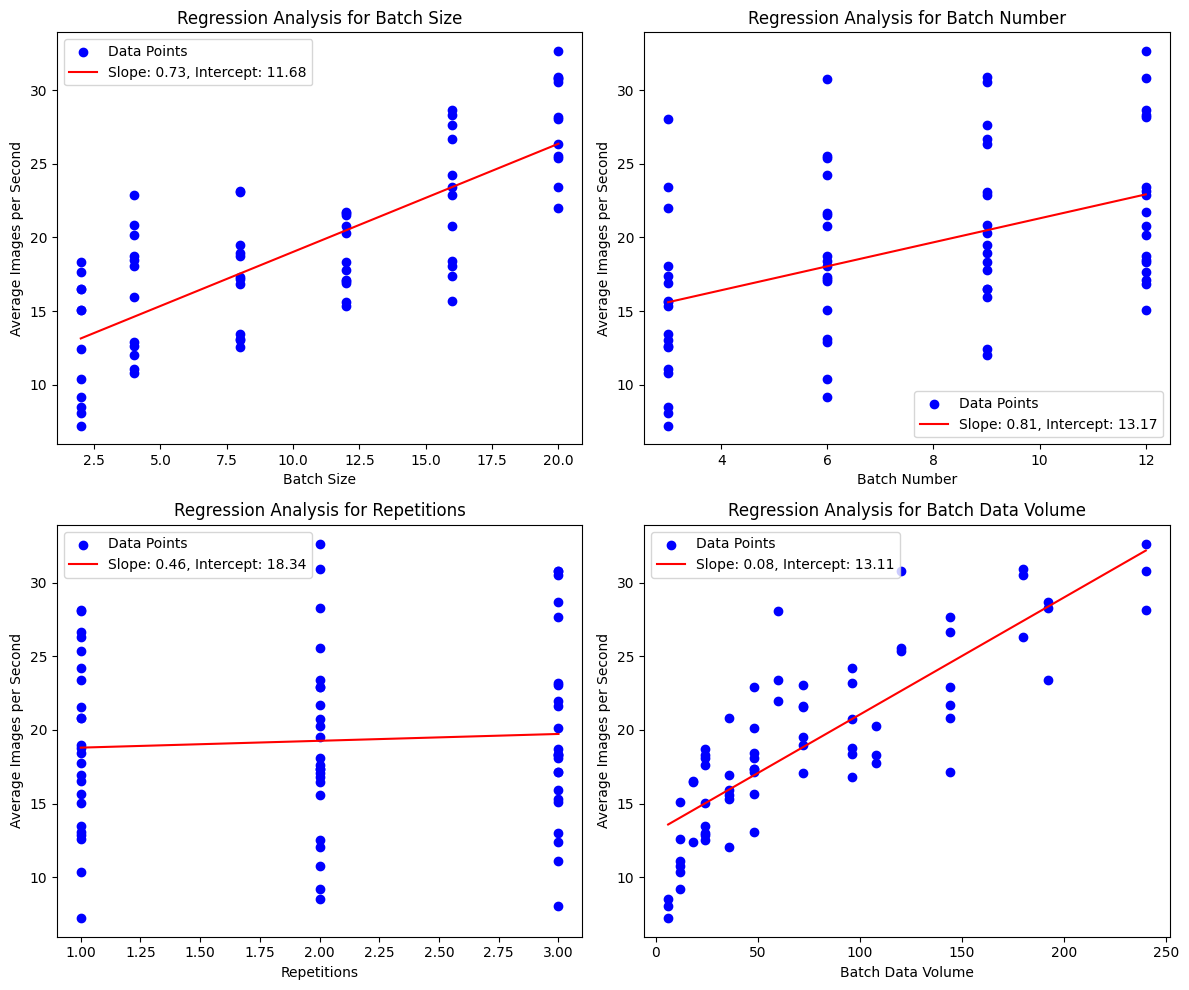

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_regression_lines(pivot_jpeg, regression_results_jpeg):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']

    for i, param in enumerate(parameters):
        ax = axes[i]
        X = pivot_jpeg[[param]]
        y = pivot_jpeg['Average Images per Second']

        # Get slopes and intercepts
        slope = regression_results_jpeg.loc[regression_results_jpeg['Parameter'] == param, 'Slope (Throughput)'].values[0]
        intercept = regression_results_jpeg.loc[regression_results_jpeg['Parameter'] == param, 'Intercept (Throughput)'].values[0]

        # Scatter plot
        ax.scatter(X, y, color='blue', label='Data Points')
        ax.set_xlabel(param)
        ax.set_ylabel('Average Images per Second')
        ax.set_title(f'Regression Analysis for {param}')

        # Plot regression line
        x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Reshape x_values
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, 'r-', label=f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Run the plotting function for JPEG dataset
plot_regression_lines(pivot_jpeg, regression_results_jpeg)

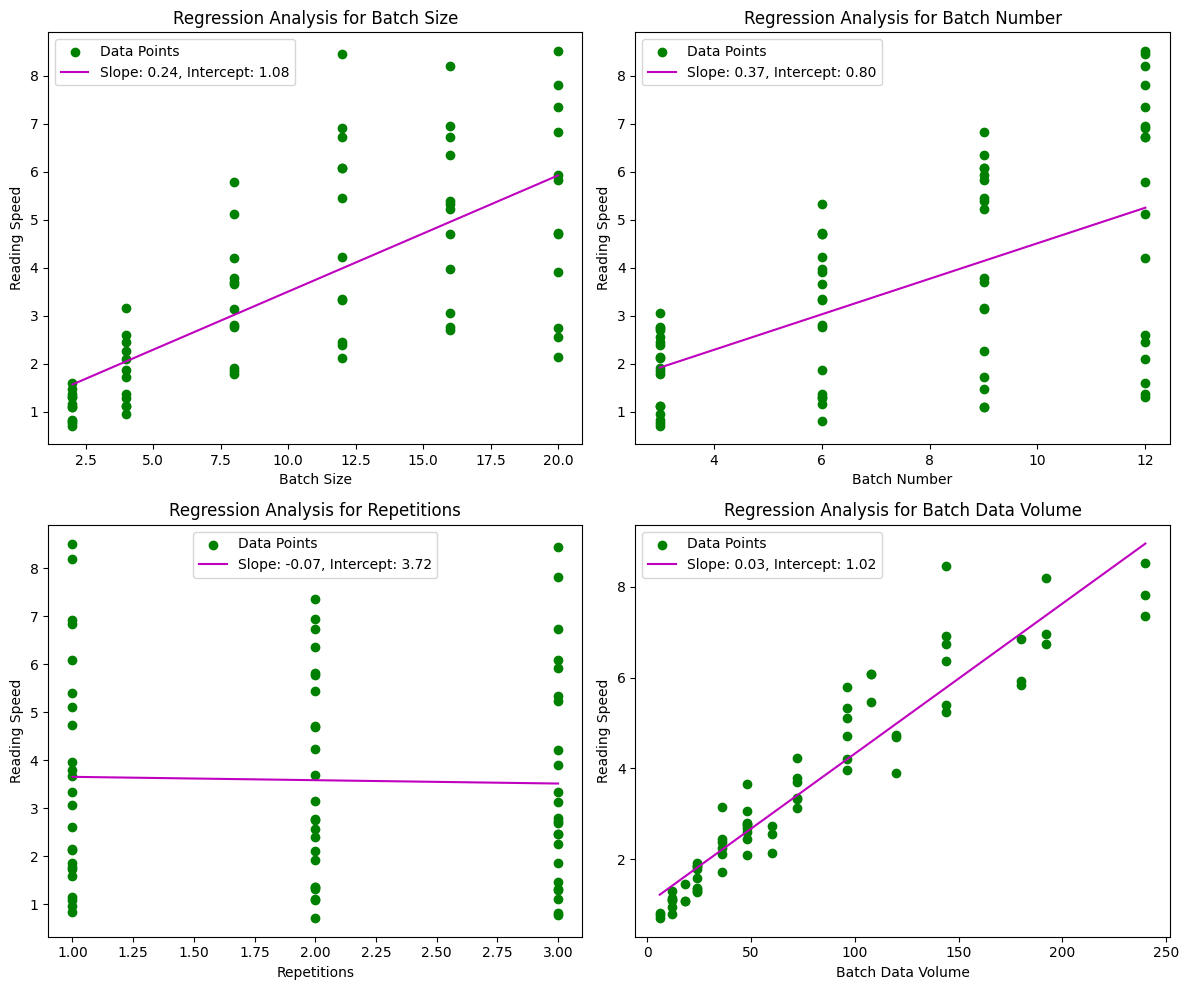

In [ ]:
# plotting the points for reading speeds for tfrecord dataset

def plot_reading_speed_regression(pivot_jpeg, regression_results_jpeg):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()
    parameters = ['Batch Size', 'Batch Number', 'Repetitions', 'Batch Data Volume']

    for i, param in enumerate(parameters):
        ax = axes[i]
        X = pivot_jpeg[[param]]
        y = pivot_jpeg['Reading Speed']

        # Get slopes and intercepts
        slope = regression_results_jpeg.loc[regression_results_jpeg['Parameter'] == param, 'Slope (Reading Speed)'].values[0]
        intercept = regression_results_jpeg.loc[regression_results_jpeg['Parameter'] == param, 'Intercept (Reading Speed)'].values[0]

        # Scatter plot
        ax.scatter(X, y, color='green', label='Data Points')
        ax.set_xlabel(param)
        ax.set_ylabel('Reading Speed')
        ax.set_title(f'Regression Analysis for {param}')

        # Plot regression line
        x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Reshape x_values
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, 'm-', label=f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Run the plotting function for reading speeds for JPEG dataset
plot_reading_speed_regression(pivot_jpeg, regression_results_jpeg)

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [7]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket

Removing gs://velvety-ground-421111-storage/_20240430-151405.pkl#1714490050211274...
Removing gs://velvety-ground-421111-storage/_20240430-151800.pkl#1714490282858327...
Removing gs://velvety-ground-421111-storage/_20240430-151803.pkl#1714490285564905...
Removing gs://velvety-ground-421111-storage/scripts/spark_job.py#1714481421823284...
Removing gs://velvety-ground-421111-storage/scripts/spark_job_with_caching.py#1714526409897785...
Removing gs://velvety-ground-421111-storage/scripts/spark_write_tfrec.py#1714143879700613...
Removing gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_40.py#1714601169483617...
Removing gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_80.py#1714400264213347...
Removing gs://velvety-ground-421111-storage/scripts/spark_write_tfrec_parellel.py#1714418177919677...
Removing gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec#1714393068461838...
Removing gs://velvety-ground-421111-storage/tfrecords-jpeg-192x192